In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Unsupervised Learning with MLlib") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

Membuat koneksi awal ke engine Apache Spark. Cell ini adalah fondasi untuk memulai semua operasi Spark.
- appName memberi nama pada aplikasi (penting saat memonitor di Spark UI).
- config("spark.executor.memory", "4g") memberikan masing-masing executor memori 4GB.
- getOrCreate() memastikan SparkSession hanya dibuat sekali (idempotent).

In [ ]:
from pyspark.ml.linalg import Vectors

data = [
    (Vectors.dense([5.1, 3.5, 1.4, 0.2]),),
    (Vectors.dense([4.9, 3.0, 1.4, 0.2]),),
    (Vectors.dense([4.7, 3.2, 1.3, 0.2]),),
    (Vectors.dense([7.0, 3.2, 4.7, 1.4]),),
    (Vectors.dense([6.4, 3.2, 4.5, 1.5]),),
    (Vectors.dense([6.9, 3.1, 4.9, 1.5]),)
]

df = spark.createDataFrame(data, ["features"])

Membuat dataset sederhana berupa vektor berdimensi 4 (mirip dataset bunga iris) dan mengemasnya dalam DataFrame Spark.
- Setiap baris adalah satu data poin dengan empat fitur numerik.
- Disimpan dalam kolom bernama "features".

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True)

scaled_df = scaler.fit(df).transform(df)


Melakukan standardisasi fitur (mean = 0, std = 1) agar semua fitur berada dalam skala yang sama.
Hal ini penting untuk algoritma seperti K-Means, yang sensitif terhadap skala data.
- Outputnya adalah DataFrame baru dengan kolom tambahan scaled_features.

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(scaled_df)

# Prediksi cluster
predictions = model.transform(scaled_df)
predictions.show()

+-----------------+--------------------+----------+
|         features|     scaled_features|prediction|
+-----------------+--------------------+----------+
|[5.1,3.5,1.4,0.2]|[-0.6983599143217...|         1|
|[4.9,3.0,1.4,0.2]|[-0.8888217091367...|         1|
|[4.7,3.2,1.3,0.2]|[-1.0792835039517...|         1|
|[7.0,3.2,4.7,1.4]|[1.11102713642096...|         0|
|[6.4,3.2,4.5,1.5]|[0.53964175197589...|         2|
|[6.9,3.1,4.9,1.5]|[1.01579623901345...|         0|
+-----------------+--------------------+----------+



Melatih model K-Means untuk membagi data menjadi 3 cluster (K=3).
- fit(...) mempelajari posisi centroid dari data.
- transform(...) menambahkan kolom "prediction" ke DataFrame, yaitu label cluster untuk setiap baris.

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Within Set Sum of Squared Errors

# Dengan ini:
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

Silhouette with squared euclidean distance = 0.7692979876379087
Within Set Sum of Squared Errors = 0.24833333333333313


Menilai kualitas hasil clustering dengan dua metrik:
- Silhouette Score: mengukur seberapa baik masing-masing data cocok dengan cluster-nya (nilai dekat 1 = baik).
- WSSSE: total jarak kuadrat antara data dan centroid-nya (semakin kecil = lebih kompak).

K=2, WSSSE=0.5133333333333331
K=3, WSSSE=0.24833333333333313
K=4, WSSSE=0.08000000000000007
K=5, WSSSE=0.03500000000000002
K=6, WSSSE=0.0


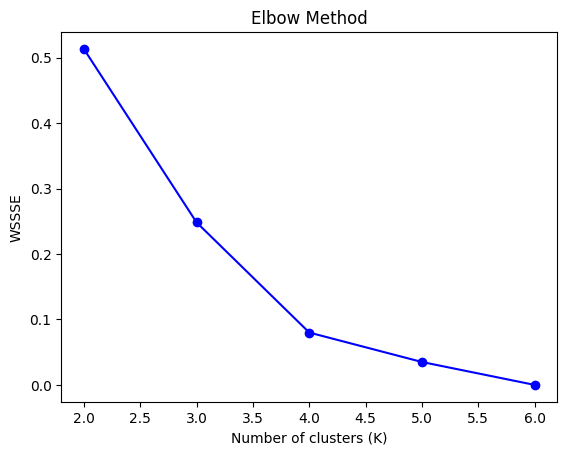

In [ ]:
import matplotlib.pyplot as plt

costs = []
for k in range(2, 7):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(scaled_df)
    costs.append(model.summary.trainingCost)  # Gunakan trainingCost
    print(f"K={k}, WSSSE={costs[-1]}")

# Visualisasi
import matplotlib.pyplot as plt
plt.plot(range(2, 7), costs, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WSSSE')
plt.title('Elbow Method')
plt.show()

Menguji beberapa nilai K (jumlah cluster) dari 2 hingga 6, lalu menghitung WSSSE untuk masing-masing.
- Visualisasi Elbow membantu memilih jumlah cluster optimal (titik tekuk di grafik menunjukkan K terbaik).

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)

# Transform data
pca_result = pca_model.transform(scaled_df)
pca_result.select("pca_features").show(truncate=False)

+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-3.5540691264840634,-5.181690130080334]|
|[-3.4683844688148184,-4.750235698266647]|
|[-3.2887208403812265,-4.753062654835078]|
|[-7.550562728189455,-5.077394269765552] |
|[-7.135091699496945,-4.679675606096402] |
|[-7.701700199921556,-4.86375149478825]  |
+----------------------------------------+



Menggunakan Principal Component Analysis (PCA) untuk mereduksi dimensi data dari 4D → 2D.
- Ini dilakukan agar data bisa divisualisasikan dan pola cluster bisa dilihat secara visual.

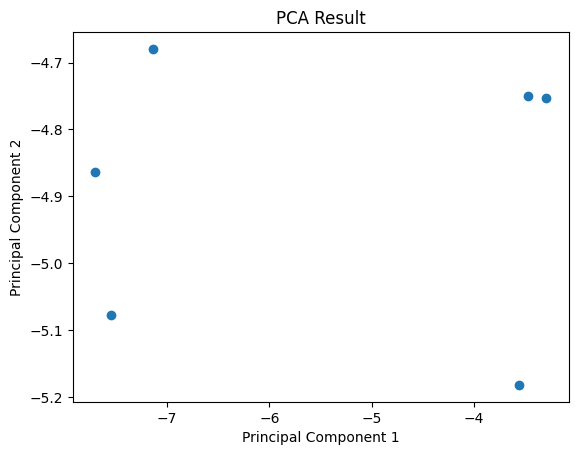

In [ ]:
import numpy as np

# Ekstrak komponen utama
pca_data = pca_result.select("pca_features").rdd.map(lambda x: x[0]).collect()
x = [float(d[0]) for d in pca_data]
y = [float(d[1]) for d in pca_data]

plt.scatter(x, y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.show()

Mengambil hasil PCA dan menggambarkannya dalam grafik 2D scatter plot.
- Membantu melihat distribusi alami dari data setelah dimensi dikurangi.

In [ ]:
kmeans_pca = KMeans().setK(3).setSeed(1).setFeaturesCol("pca_features")
pca_kmeans_model = kmeans_pca.fit(pca_result)

# Prediksi cluster
pca_predictions = pca_kmeans_model.transform(pca_result)
pca_predictions.select("pca_features", "prediction").show()

+--------------------+----------+
|        pca_features|prediction|
+--------------------+----------+
|[-3.5540691264840...|         1|
|[-3.4683844688148...|         1|
|[-3.2887208403812...|         1|
|[-7.5505627281894...|         0|
|[-7.1350916994969...|         2|
|[-7.7017001999215...|         0|
+--------------------+----------+



Melakukan ulang proses K-Means, tetapi menggunakan data hasil PCA (2D).
- Ini berguna untuk evaluasi atau visualisasi yang lebih sederhana.

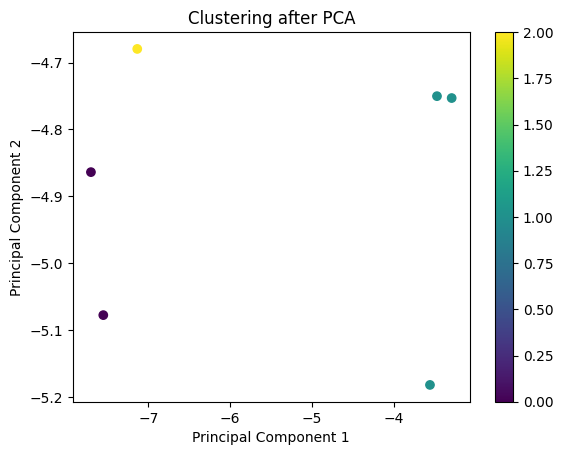

In [ ]:
# Gabungkan hasil clustering dengan data PCA
cluster_data = pca_predictions.select("pca_features", "prediction").collect()
x = [float(d[0][0]) for d in cluster_data]
y = [float(d[0][1]) for d in cluster_data]
clusters = [int(d[1]) for d in cluster_data]

plt.scatter(x, y, c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering after PCA')
plt.colorbar()
plt.show()

Membuat visualisasi akhir dari hasil clustering setelah data direduksi dengan PCA.
- Titik-titik diberi warna sesuai cluster-nya.
- Membantu memverifikasi apakah cluster yang ditemukan secara visual terpisah dengan baik.